In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Hourly
from meteostat import Point

2023-04-25 10:30:53.129254: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-25 10:30:53.182386: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-25 10:30:53.183080: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 10:30:54.054723: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df_t = pd.read_csv('temperature.csv',index_col=0)
df_h = pd.read_csv('humidity.csv',index_col=0)
df_p = pd.read_csv('pressure.csv',index_col=0)
df_w = pd.read_csv('wind_speed.csv',index_col=0)
df_h.columns

Index(['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles',
       'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver',
       'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis',
       'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta',
       'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh',
       'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston',
       'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya',
       'Jerusalem'],
      dtype='object')

In [3]:
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

In [4]:
sd = Point(32.7338, 117.1933)

In [5]:
# data units
# ① Humidity (%), ② Pressure (hPa), ③ Temperature (K), 4) Wind Speed (m/s).

# sd coordinates: 32.7157° N, 117.1611° W


# Set time period
start = datetime(2021, 1, 1)
end = datetime(2023, 4, 23, 23, 59)

# Get hourly data
data = Hourly(sd, start, end)
data = data.fetch()

# Print DataFrame
features = data[['temp','pres','rhum','wspd']]


def f(x):
    x = x + 273.15
    return float(x)


features['temp'] = features['temp'].map(lambda a: a+273.15)

features

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,temp,pres,rhum,wspd
time,,,,
2021-01-01 00:00:00,267.75,1031.2,72.0,5.5
2021-01-01 01:00:00,270.45,1030.8,58.0,9.3
2021-01-01 02:00:00,273.05,1030.5,47.0,11.1
2021-01-01 03:00:00,275.75,1030.2,38.0,14.8
2021-01-01 04:00:00,277.25,1028.8,32.0,14.8
...,...,...,...,...
2023-04-23 19:00:00,282.35,1024.0,89.0,16.7
2023-04-23 20:00:00,282.25,1024.2,89.0,16.7
2023-04-23 21:00:00,282.25,1024.3,87.0,14.8


In [6]:
training_size = int ( 0.8 * features.shape[0])  

dataset=features.values
data_mean = dataset[:training_size].mean(axis=0)
data_std = dataset[:training_size].std(axis=0)
dataset = (dataset-data_mean)/data_std

dataset.shape

(20232, 4)

In [7]:
features = normalize(features.values)
features = pd.DataFrame(features)
features

,0,1,2,3
0,-2.098871,1.389244,-0.013220,-0.819334
1,-1.828344,1.349501,-0.776165,-0.031613
2,-1.567836,1.319693,-1.375622,0.341518
3,-1.297308,1.289885,-1.866087,1.108510
4,-1.147015,1.150782,-2.193063,1.108510
...,...,...,...,...
20227,-0.636019,0.673857,0.913213,1.502370
20228,-0.646039,0.693729,0.913213,1.502370
20229,-0.646039,0.703665,0.804221,1.108510
20230,-0.575902,0.753345,0.586237,1.108510


In [8]:
past_history = 72
future_target = 24
STEP = 1

In [9]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [10]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 training_size, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             training_size, None, past_history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)

(16113, 72, 4)
(16113, 24)


In [11]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (72, 4)

 Target temperature to predict : (24,)


In [12]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() # .repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat() # .repeat()

2023-04-25 10:30:55.954357: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [13]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.xlabel('timestamp', fontsize=12)
  plt.ylabel('temperature', fontsize=12)
  plt.show()

In [22]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='tanh'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

2023-04-25 10:32:54.690142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-25 10:32:54.691801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-25 10:32:54.693137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [23]:
EVALUATION_INTERVAL = 250
EPOCHS = 6

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/6


2023-04-25 10:32:55.209622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-25 10:32:55.211385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-25 10:32:55.212860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

250/250 [==============================] - ETA: 0s - loss: 0.2534

2023-04-25 10:33:11.489092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-25 10:33:11.490800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-25 10:33:11.492144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

250/250 [==============================] - 18s 58ms/step - loss: 0.2534 - val_loss: 0.1620
Epoch 2/6
250/250 [==============================] - 14s 55ms/step - loss: 0.0689 - val_loss: 0.1262
Epoch 3/6
250/250 [==============================] - 14s 56ms/step - loss: 0.0583 - val_loss: 0.1200
Epoch 4/6
250/250 [==============================] - 14s 55ms/step - loss: 0.0527 - val_loss: 0.1135
Epoch 5/6
250/250 [==============================] - 14s 56ms/step - loss: 0.0477 - val_loss: 0.1144
Epoch 6/6
250/250 [==============================] - 14s 56ms/step - loss: 0.0435 - val_loss: 0.1139


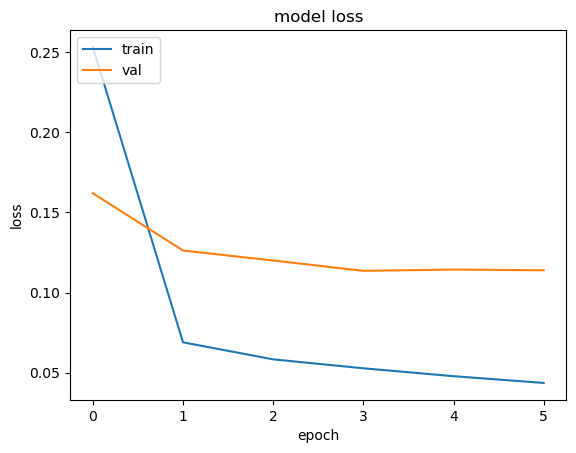

In [24]:
# Plot training loss and validation
fig1 = plt.figure()
plt.plot(multi_step_history.history['loss'])
plt.plot(multi_step_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig1.show()

In [25]:
def create_time_steps(length):
  return list(range(-length, 0))

In [26]:
def denormalize(a):
    #     data_mean = dataset[:training_size].mean(axis=0)
    #     data_std = dataset[:training_size].std(axis=0)
    #     dataset = (dataset-data_mean)/data_std
    return a*data_std[0]+data_mean[0]-273.15

In [27]:
denorm = np.vectorize(denormalize)

2023-04-25 10:34:22.802764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [3951,24]
	 [[{{node Placeholder/_1}}]]
2023-04-25 10:34:23.341783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-25 10:34:23.343630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor

8/8 [==============================] - 1s 9ms/step


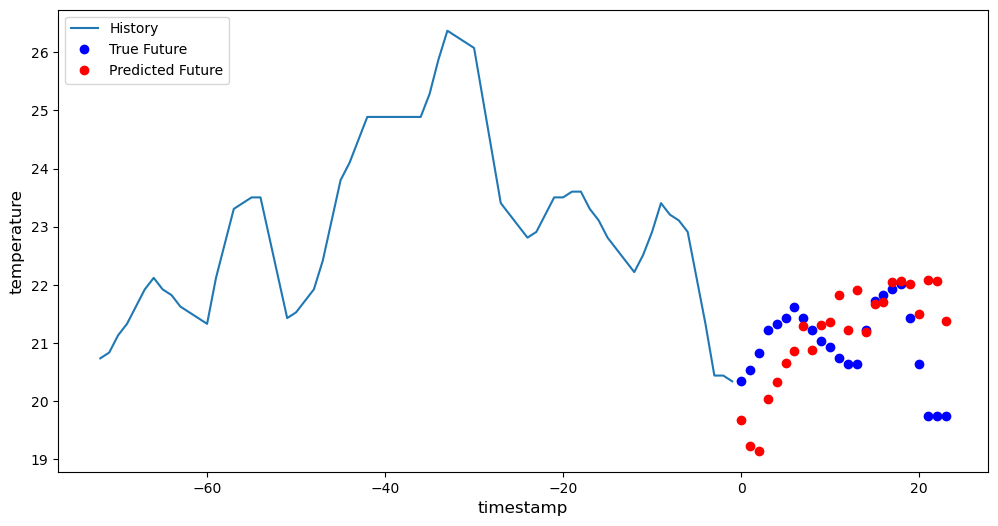

8/8 [==============================] - 0s 9ms/step


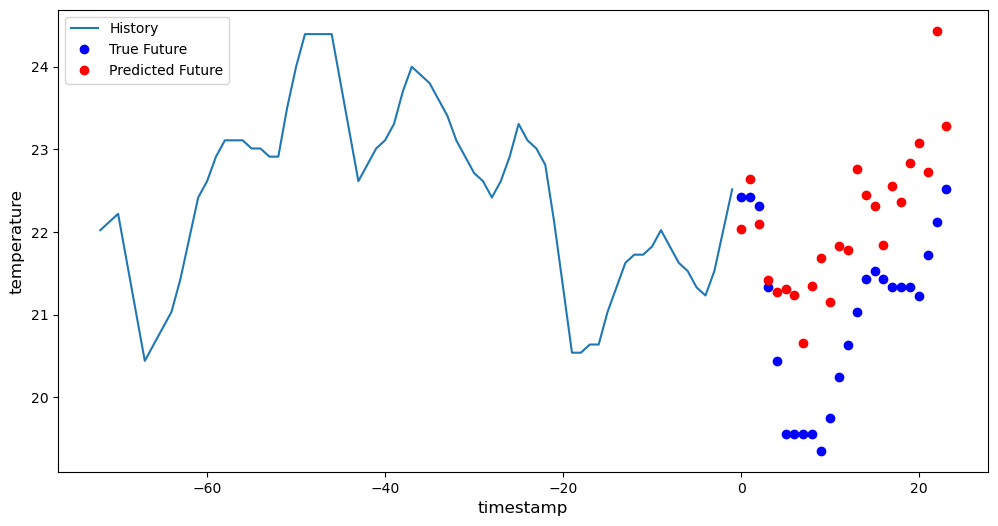

8/8 [==============================] - 0s 9ms/step


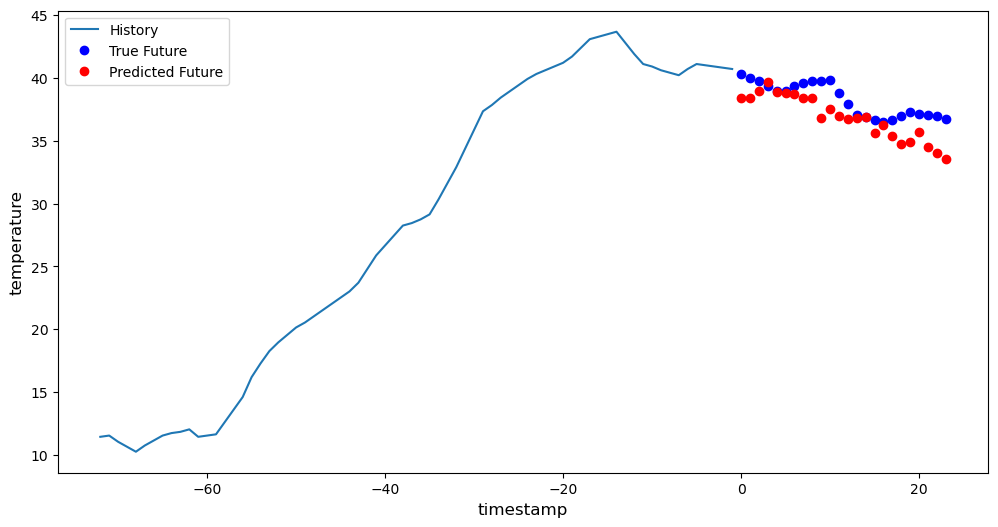

8/8 [==============================] - 0s 9ms/step


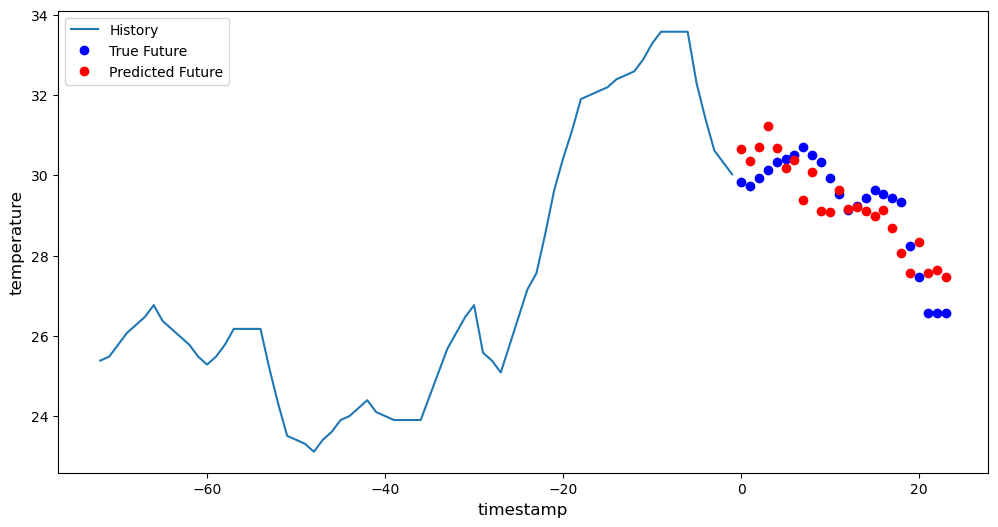

8/8 [==============================] - 0s 8ms/step


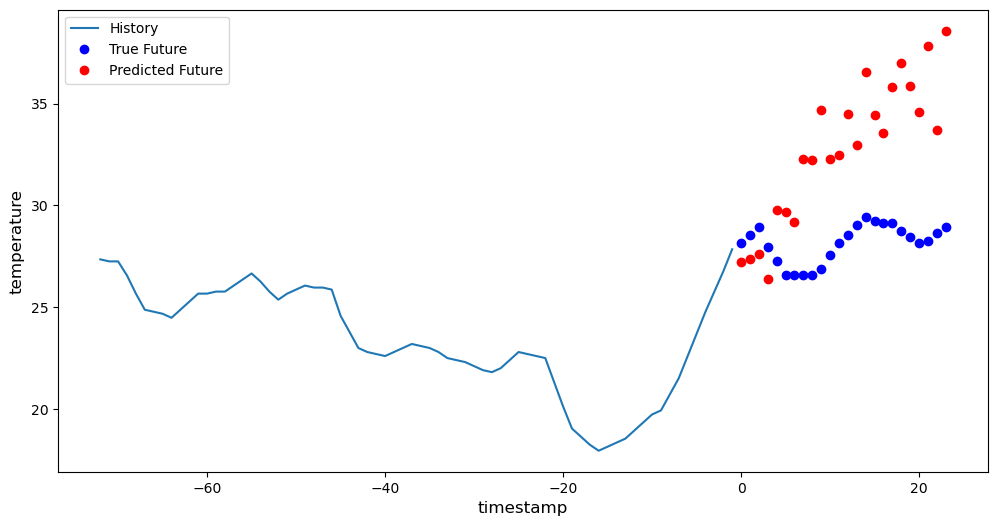

8/8 [==============================] - 0s 9ms/step


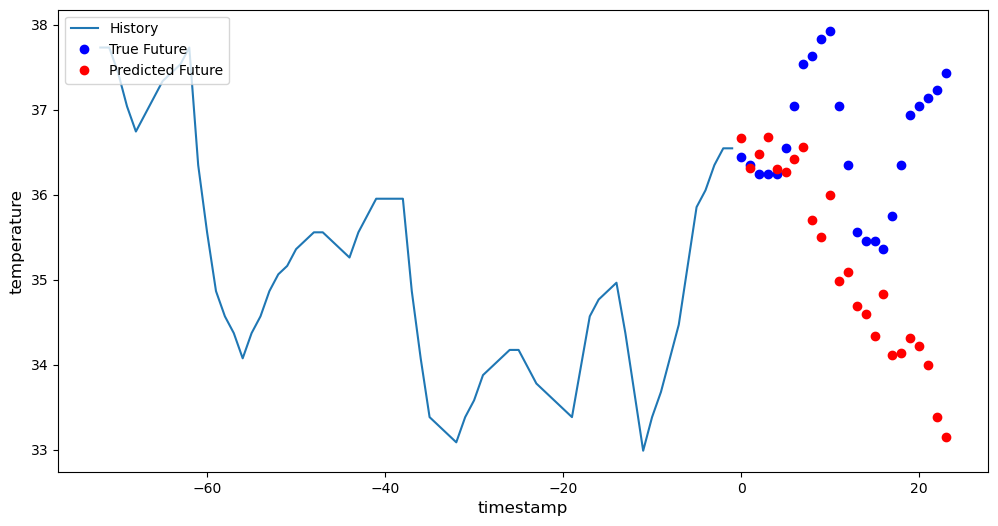

8/8 [==============================] - 0s 9ms/step


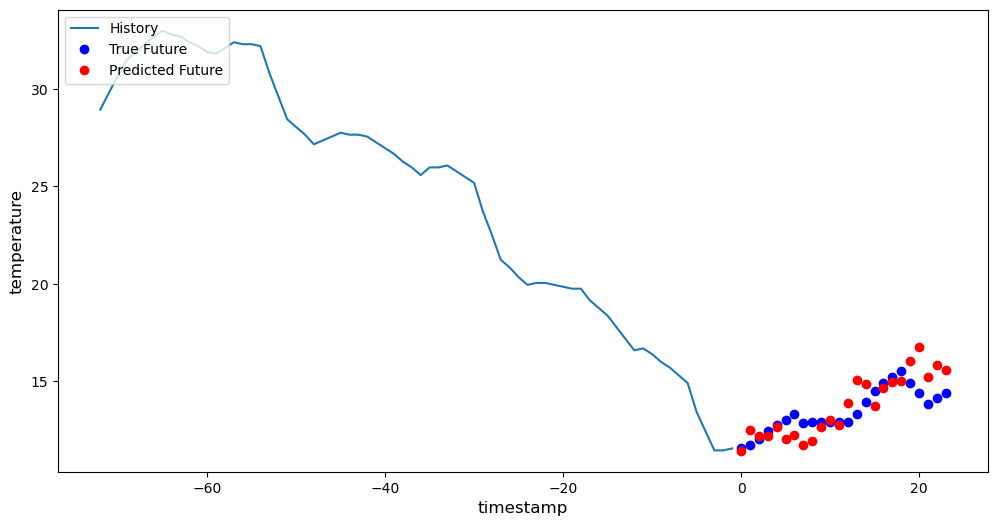

8/8 [==============================] - 0s 9ms/step


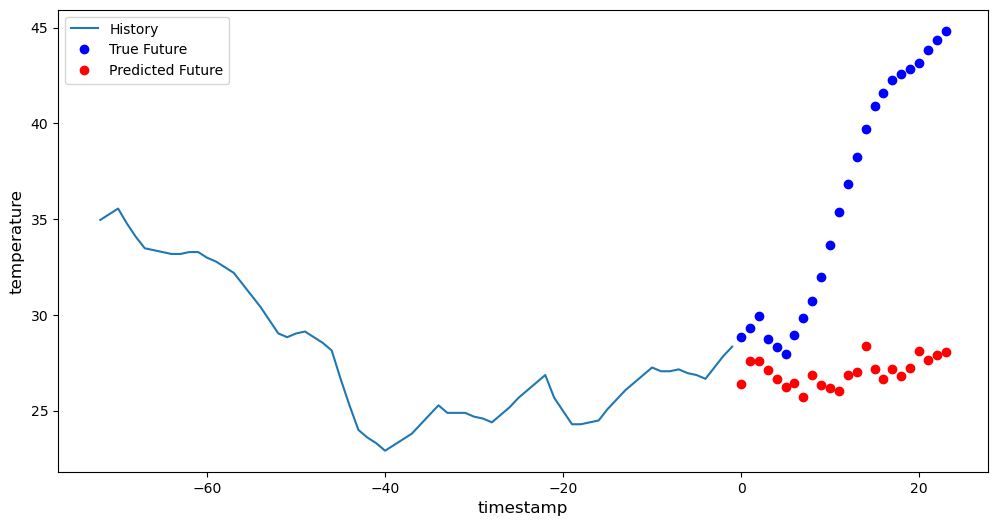

8/8 [==============================] - 0s 9ms/step


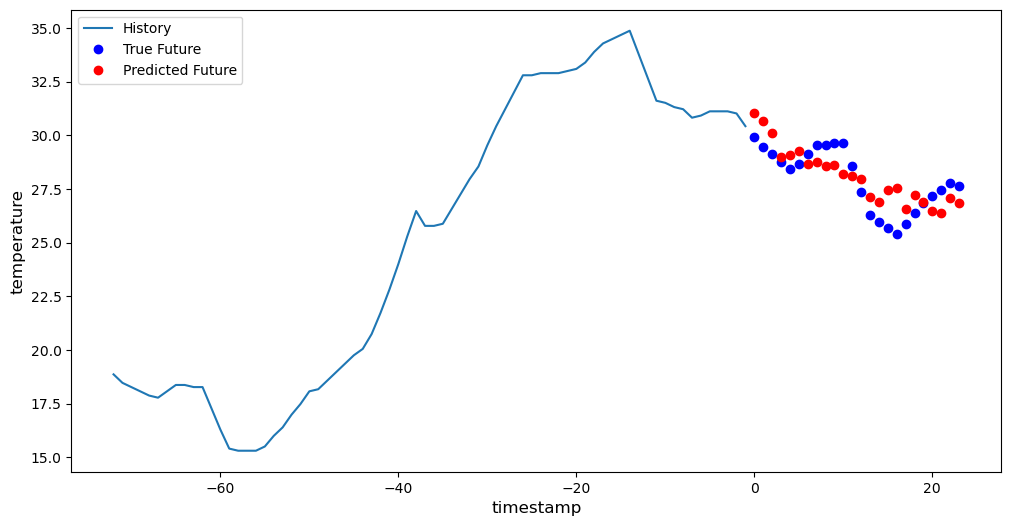

8/8 [==============================] - 0s 9ms/step


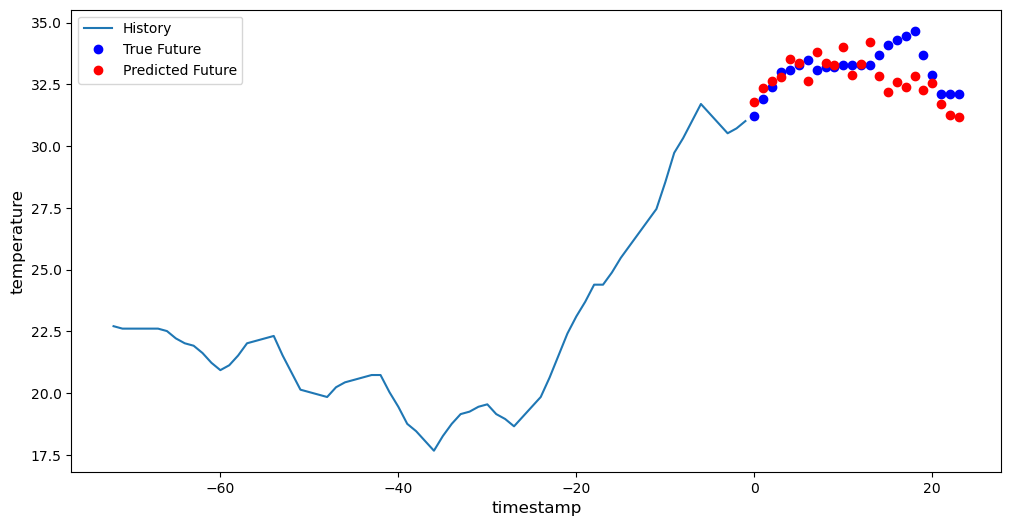

8/8 [==============================] - 0s 9ms/step


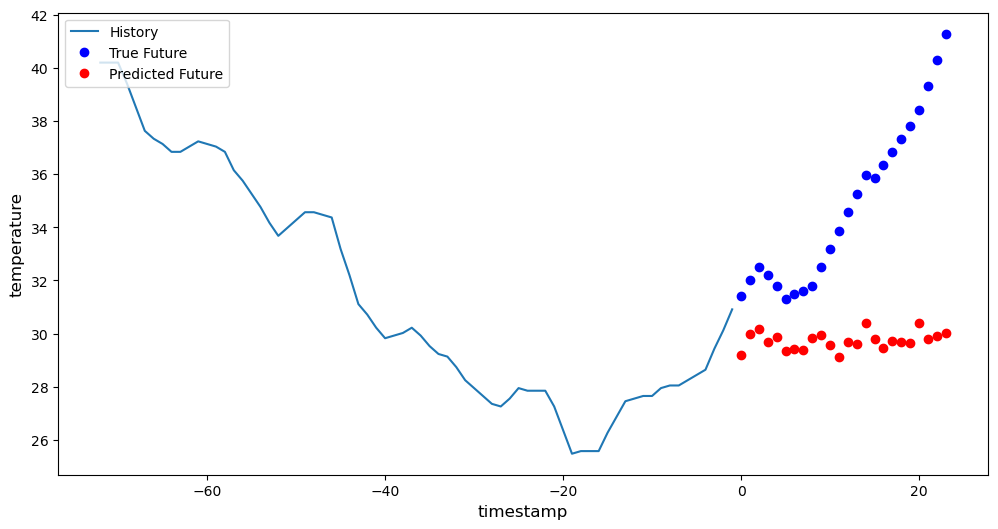

8/8 [==============================] - 0s 9ms/step


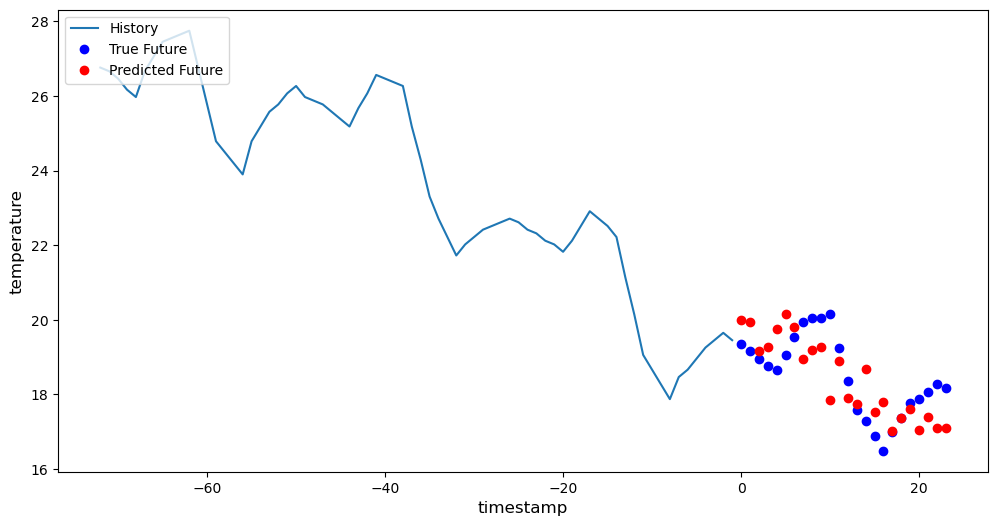

8/8 [==============================] - 0s 8ms/step


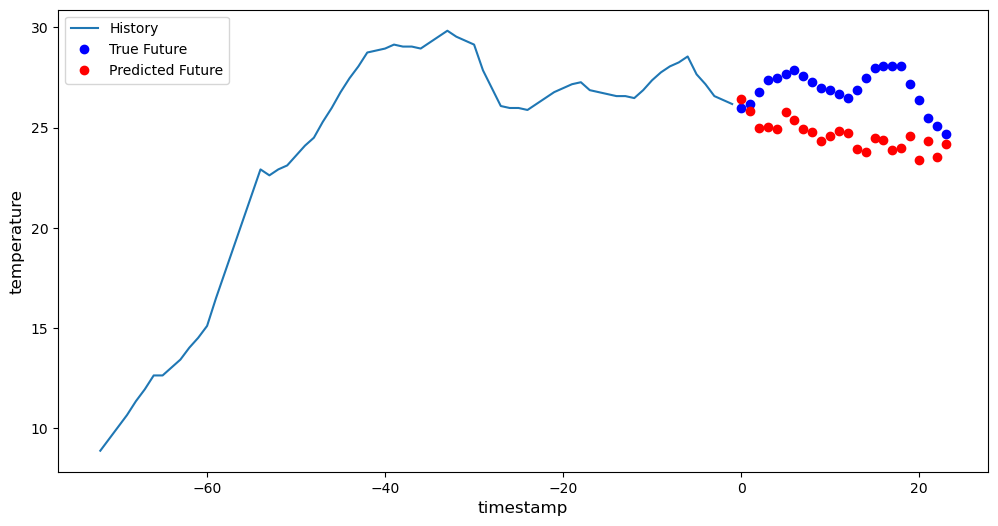

8/8 [==============================] - 0s 9ms/step


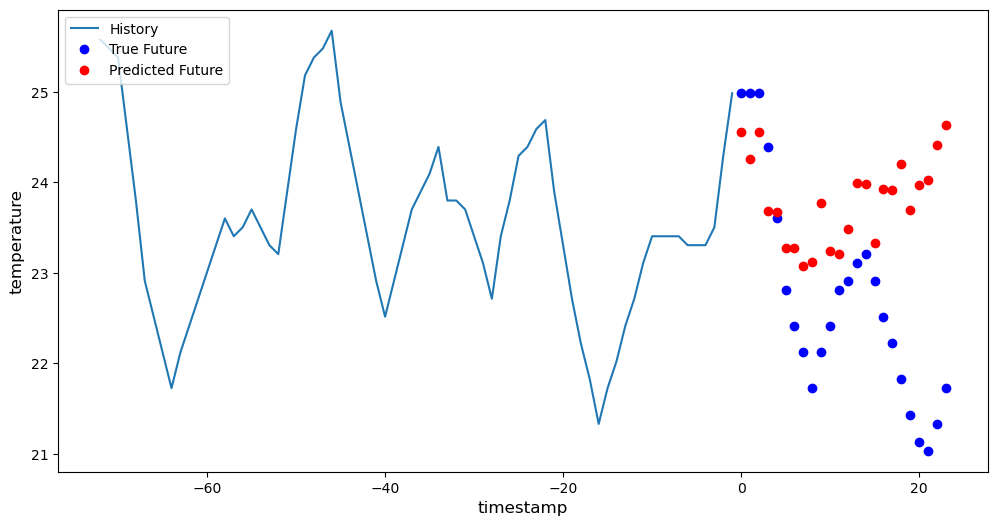

8/8 [==============================] - 0s 9ms/step


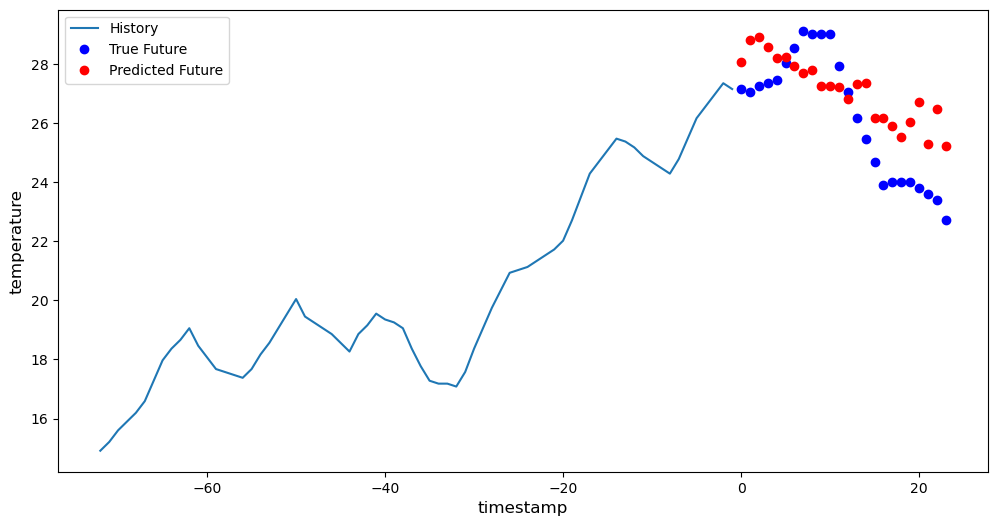

2023-04-25 10:34:28.451780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-25 10:34:28.453495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-25 10:34:28.454880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 9ms/step


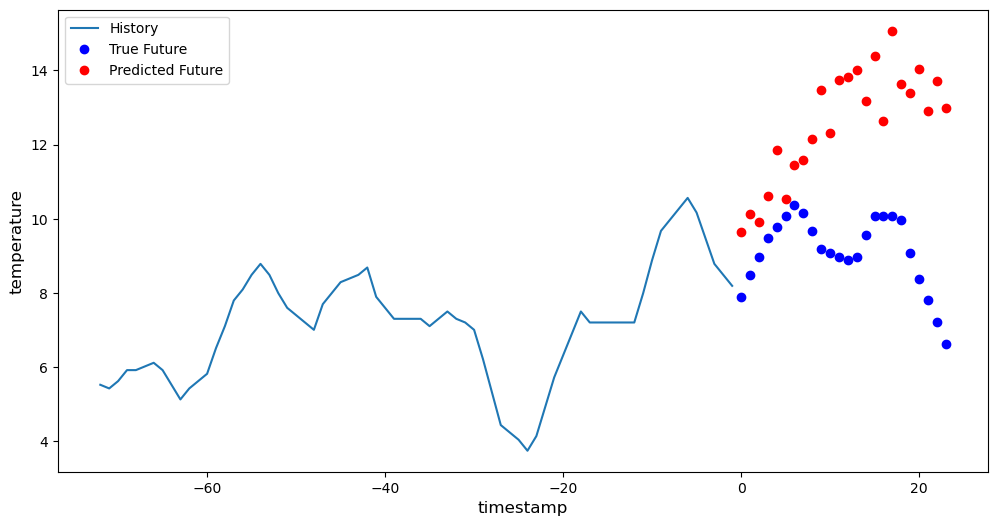

8/8 [==============================] - 0s 8ms/step


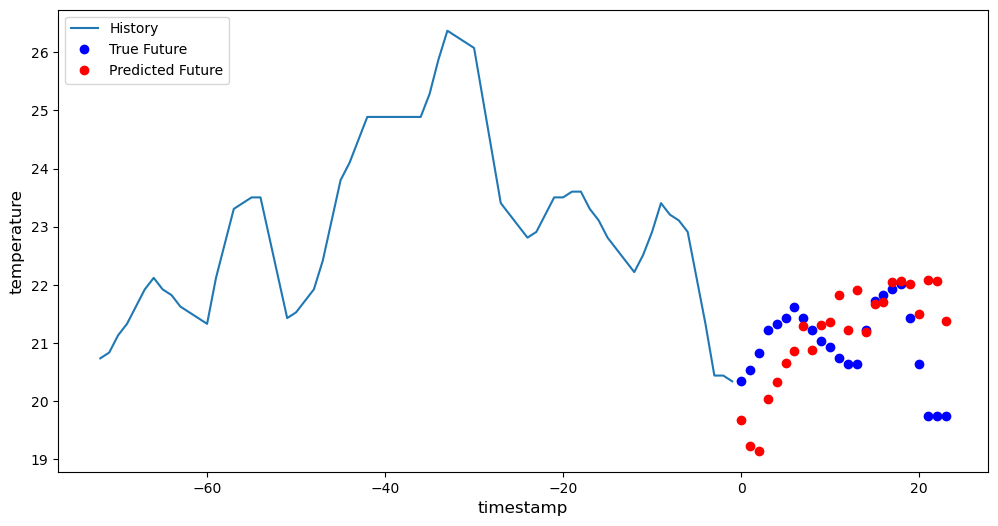

8/8 [==============================] - 0s 9ms/step


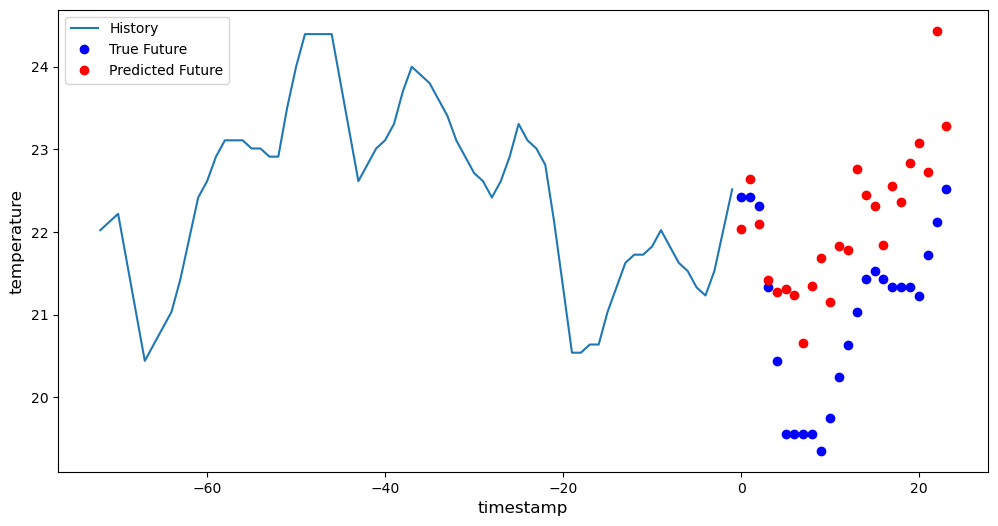

8/8 [==============================] - 0s 9ms/step


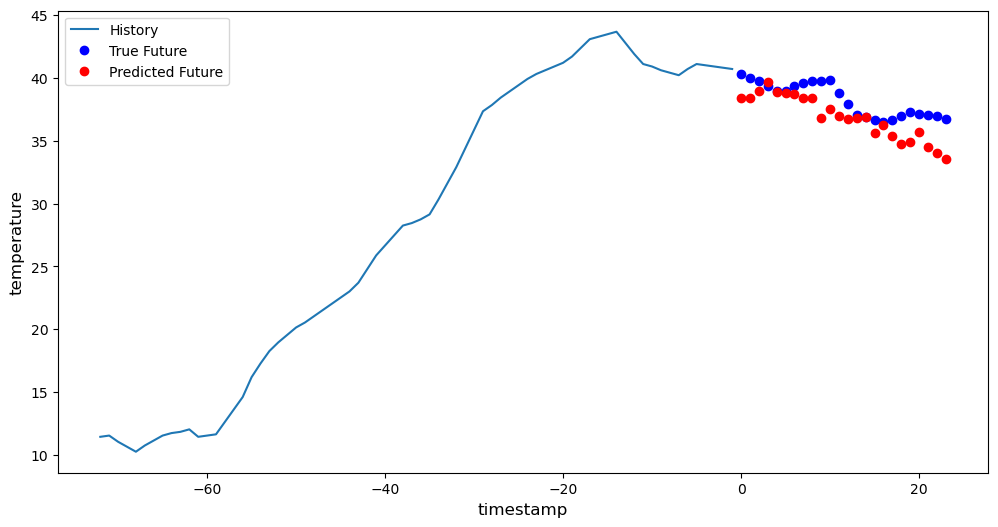

8/8 [==============================] - 0s 8ms/step


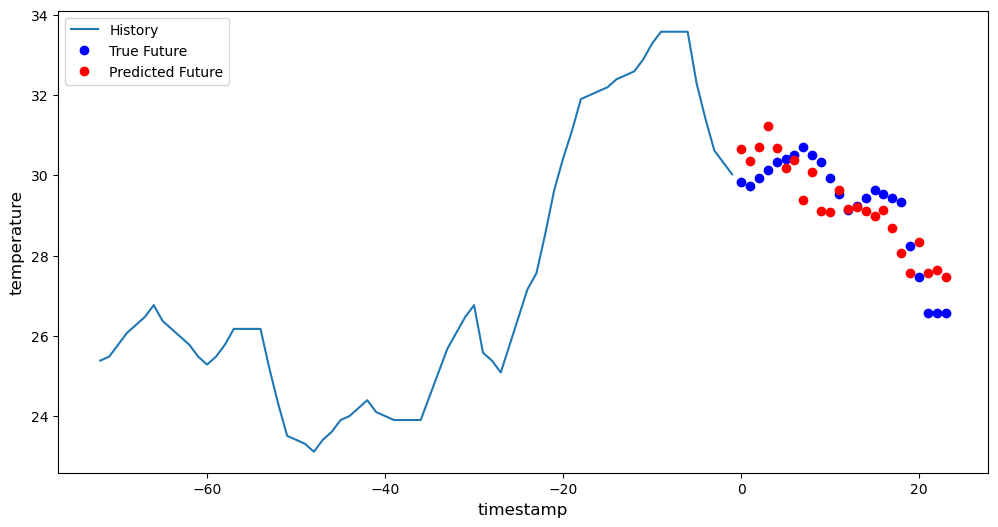

In [28]:
for x, y in val_data_multi.take(20):
  multi_step_plot(denorm(x[0]), denorm(y[0]), denorm(multi_step_model.predict(x)[0]))

In [21]:
import gradio as gr

api = gr.Interface.load("huggingface/EleutherAI/gpt-j-6B")


def predict_temp(text):
    # Use the last 50 characters of the text as context
    return "asdf"


with gr.Blocks() as demo:
    City = gr.Textbox(placeholder="Enter the city you want to be used to see how the model works on it (make sure to spell it right)...", lines=4, label="City Name")
    btn = gr.Button("Generate")
    Output = gr.Textbox(label="Output Box")

    btn.click(predict_temp, City, Output)

demo.launch(share=True)


Fetching model from: https://huggingface.co/EleutherAI/gpt-j-6B
Running on local URL:  http://127.0.0.1:7863

Could not create share link, please check your internet connection.
